#### NOVA IMS / BSc in Data Science / Text Mining 2024/2025
### <b>Group Project: "Solving the Hyderabadi Word Soup"</b>
#### Notebook `Data Exploration & Visualization`

#### Group 10:
- `Adriana Pinto - 20221921`
- `David Duarte - 20221899`
- `Maria Teresa Silva - 20221821`
- `Marta Alves - 20221890` 
- `Miguel Nascimento - 20221876` 

#### <font color='#BFD72'>Table of Contents </font> <a class="anchor" id='toc'></a> 
- [1. Imports](#imports)
- [2. Restaurants Data Exploration](#restaurant-data-exploration)
- [3. Reviews Data Exploration](#reviews-data-exploration)

# <font color='#BFD72'>Imports</font>
[Back to TOC](#toc)

In [64]:
%reload_ext autoreload
%autoreload 2

import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from utils.graphs import *
from utils.preproc_utils import main_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

#without truncation
pd.set_option('display.max_colwidth', None)

In [ ]:
reviews = pd.read_pickle('data/reviews_initial_preproc.pkl')
restaurants = pd.read_pickle('data/restaurants_initial_preproc.pkl')

# <font color='#BFD72'>Restaurant Data Exploration</font>
[Back to TOC](#toc)

In [16]:
restaurants.head()

Name  Cost  \
0                 Beyond Flavours   800   
1                        Paradise   800   
2                        Flechazo  1300   
3  Shah Ghouse Hotel & Restaurant   800   
4      Over The Moon Brew Company  1200   

                                                                                                                          Collections  \
0  [Food Hygiene Rated Restaurants in Hyderabad, Corporate Favorites, Great Buffets, Top-Rated, Gold Curated, Live Sports Screenings]   
1                                                                                                               [Hyderabad's Hottest]   
2                                                                                                [Great Buffets, Hyderabad's Hottest]   
3                                                                                                            [Late Night Restaurants]   
4                       [Best Bars & Pubs, Food Hygiene Rated Restaurants in Hyderabad, Top-Rated, Gold Curated, Hyderabad's Hottest]   

                                                              Cuisines  \
0  [Chinese, Continental, Kebab, European, South Indian, North Indian]   
1                                     [Biryani, North Indian, Chinese]   
2                       [Asian, Mediterranean, North Indian, Desserts]   
3                 [Biryani, North Indian, Chinese, Seafood, Beverages]   
4           [Asian, Continental, North Indian, Chinese, Mediterranean]   

   N_collections open time closing time  
0              6        12           23  
1              1        11           23  
2              2        11           23  
3              1        12            2  
4              5        12           24

In [14]:
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Name           105 non-null    object
 1   Cost           105 non-null    int32 
 2   Collections    51 non-null     object
 3   Cuisines       105 non-null    object
 4   N_collections  105 non-null    int64 
 5   open time      105 non-null    object
 6   closing time   105 non-null    object
dtypes: int32(1), int64(1), object(5)
memory usage: 5.5+ KB


In [113]:
# For some reason the datatypes of open time and closing time were not stored
restaurants['open time'] = restaurants['open time'].astype(int)
restaurants['closing time'] = restaurants['closing time'].astype(int)

In [39]:
restaurants.describe()

Cost  N_collections   open_time  closing_time
count   105.000000     105.000000  105.000000    105.000000
mean    861.428571       1.009524   11.028571     18.971429
std     510.149730       1.451095    2.826581      8.471056
min     150.000000       0.000000    1.000000      1.000000
25%     500.000000       0.000000   11.000000     22.000000
50%     700.000000       0.000000   12.000000     23.000000
75%    1200.000000       1.000000   12.000000     23.000000
max    2800.000000       7.000000   24.000000     24.000000

In [ ]:
# there is no restaunt duplicates
restaurants['Name'].nunique()

105

In [18]:
cuisines_exploded = restaurants['Cuisines'].explode().explode()
collections_exploded = restaurants['Collections'].explode().explode()

In [30]:
restaurants.explode('Cuisines').groupby('Cuisines').agg(mean_cost=('Cost', 'mean'), count=('Name', 'count')).sort_values(by='mean_cost', ascending=False).head(10)

mean_cost  count
Cuisines                         
Modern Indian  2000.000000      2
Japanese       1700.000000      2
Malaysian      1700.000000      1
Sushi          1562.500000      4
BBQ            1550.000000      2
Italian        1532.142857     14
Goan           1500.000000      1
Asian          1460.000000     15
Mediterranean  1340.000000      5
Continental    1307.142857     21

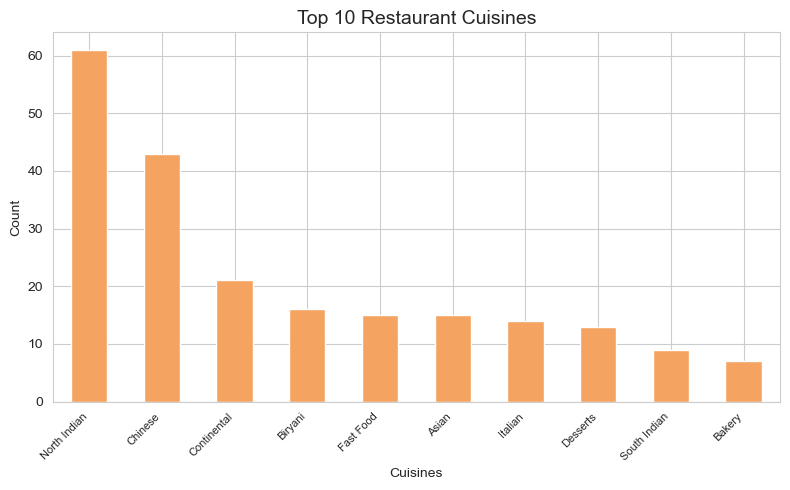

In [19]:
plot_top10_bar(cuisines_exploded)

In [31]:
restaurants.explode('Collections').groupby('Collections').agg(mean_cost=('Cost', 'mean'), count=('Name', 'count')).sort_values(by='mean_cost', ascending=False).head(10)

mean_cost  count
Collections                           
Ramzan Mubarak      2500.000000      1
Sunday Brunches     2175.000000      4
Function Venues     1950.000000      2
Great Italian       1900.000000      1
Great Breakfasts    1500.000000      2
Fancy and Fun       1450.000000      2
Barbecue & Grill    1400.000000      3
Regional Favorites  1400.000000      1
Gigs and Events     1366.666667      3
New on Gold         1350.000000      2

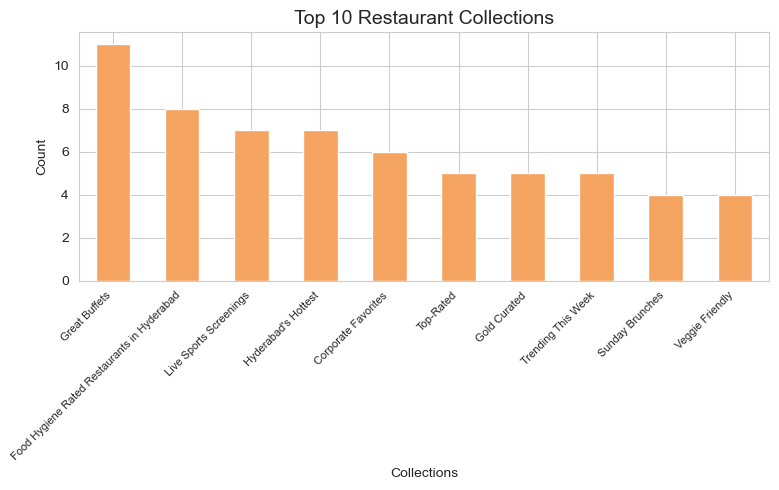

In [20]:
plot_top10_bar(collections_exploded)

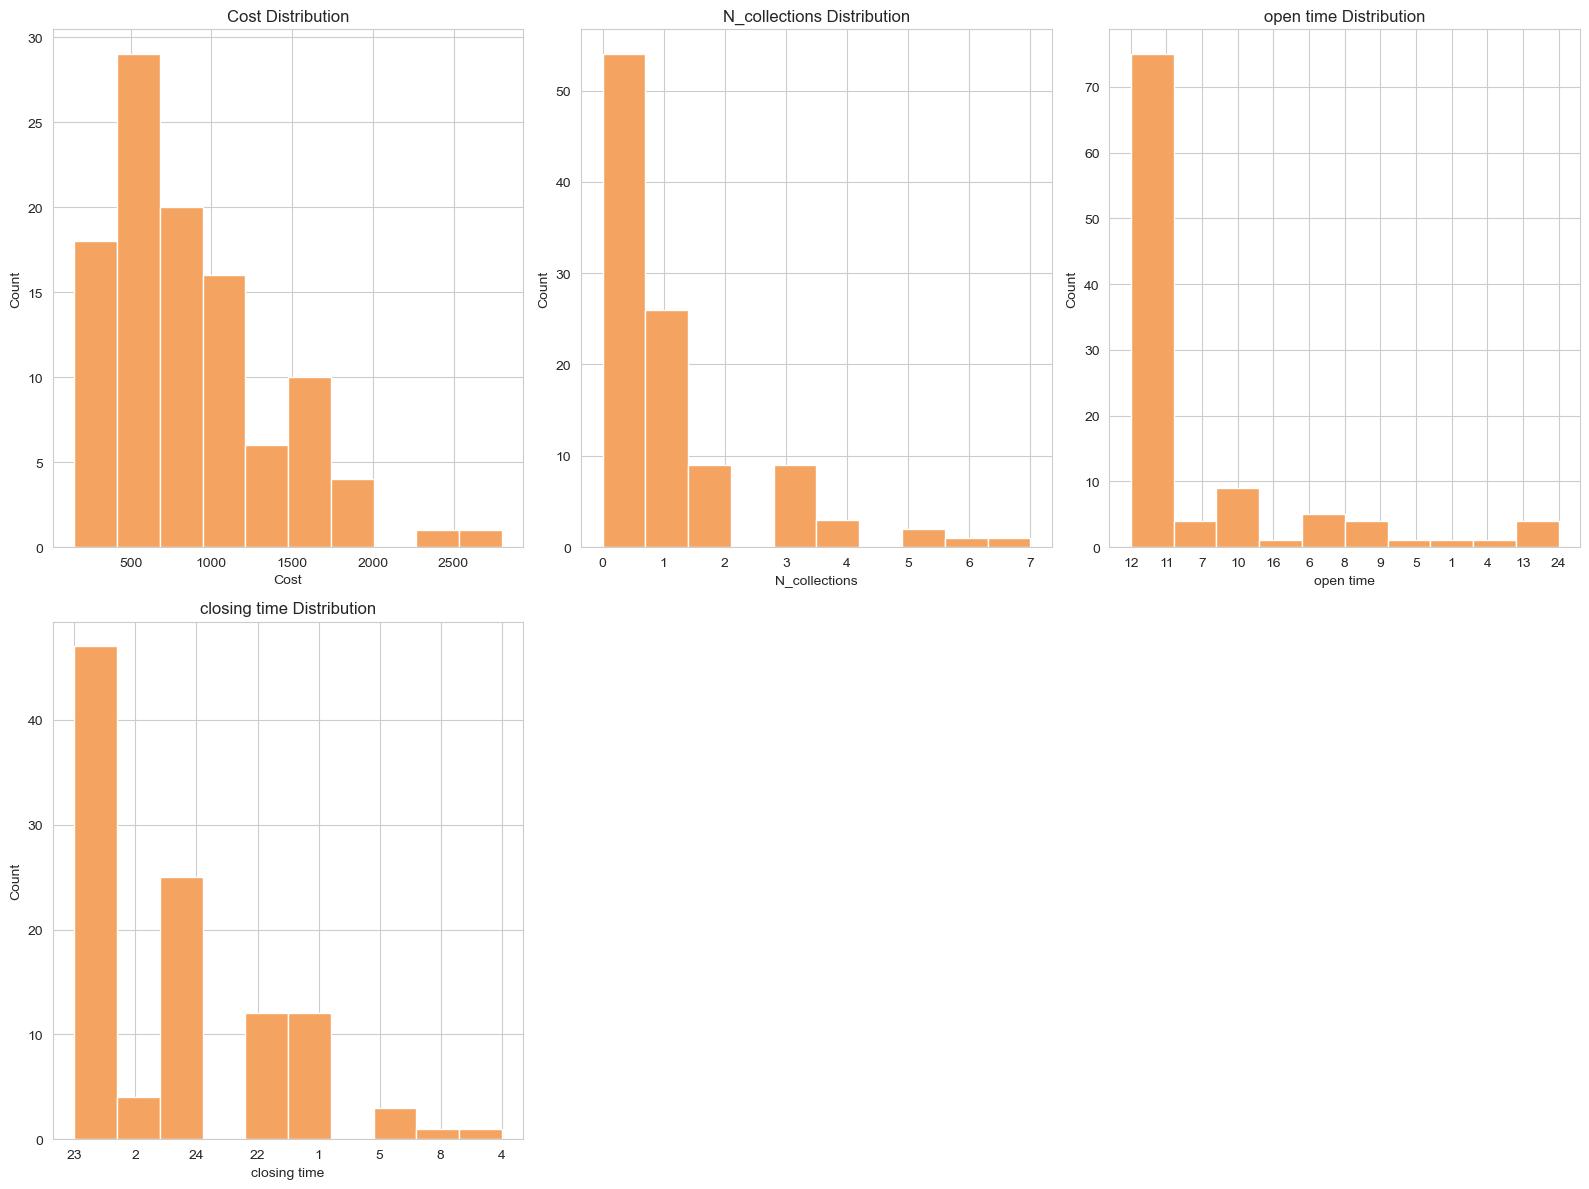

In [21]:
plot_histograms(restaurants, ['Cost','N_collections','open time','closing time'])

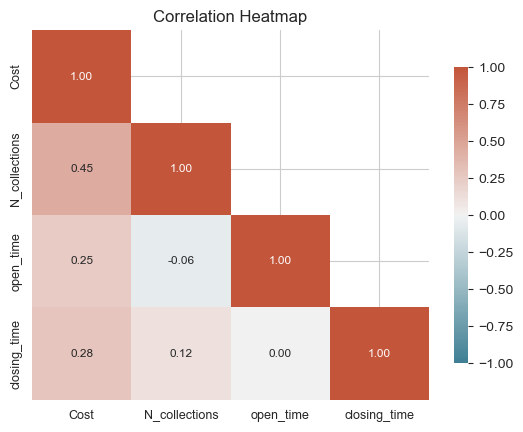

In [37]:
plot_heatmap(restaurants)

We noticed an interesting degree of correlation between N_collection and Cost. Let's check in more detail.

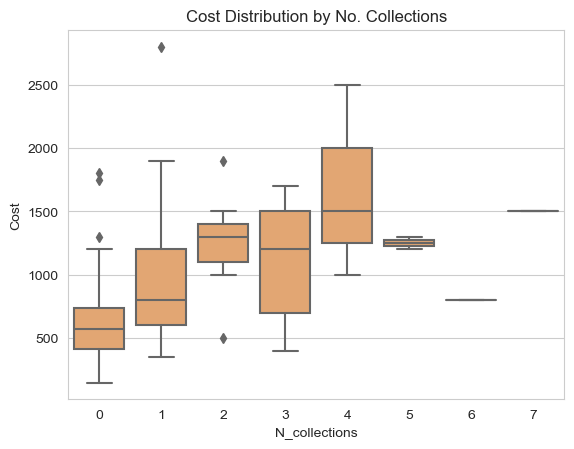

In [38]:
sns.boxplot(restaurants, x='N_collections', y='Cost', color='sandybrown').set_title('Cost Distribution by No. Collections')
plt.show()

As it is expected the higher the number of collections a restaurant belongs, the higher its cost.

# <font color='#BFD72'>Reviews Data Exploration</font>
[Back to TOC](#toc)

In [40]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9955 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Restaurant  9955 non-null   object        
 1   Reviewer    9955 non-null   object        
 2   Review      9955 non-null   object        
 3   Rating      9955 non-null   float64       
 4   Time        9955 non-null   datetime64[ns]
 5   Pictures    9955 non-null   int64         
 6   N_reviews   9949 non-null   Int64         
 7   Followers   8381 non-null   Int64         
 8   Month       9955 non-null   int32         
 9   Year        9955 non-null   int32         
 10  Weekend     9955 non-null   int64         
 11  Post_Meal   9955 non-null   int64         
 12  rev_len     9955 non-null   int64         
 13  nr_sents    9955 non-null   int64         
dtypes: Int64(2), datetime64[ns](1), float64(1), int32(2), int64(5), object(3)
memory usage: 1.1+ MB


In [41]:
reviews.describe()

Rating     Pictures  N_reviews   Followers        Month  \
count  9955.000000  9955.000000     9949.0      8381.0  9955.000000   
mean      3.600402     0.751984  23.975173  193.740723     6.016976   
std       1.483565     2.575691  50.615872  671.484517     3.160373   
min       1.000000     0.000000        0.0         1.0     1.000000   
25%       3.000000     0.000000        1.0         2.0     4.000000   
50%       4.000000     0.000000        4.0        13.0     5.000000   
75%       5.000000     0.000000       22.0        92.0     8.000000   
max       5.000000    64.000000     1031.0     13410.0    12.000000   

              Year     Weekend    Post_Meal      rev_len     nr_sents  
count  9955.000000  9955.00000  9955.000000  9955.000000  9955.000000  
mean   2018.452436     0.35781     0.538322   281.468106     4.067102  
std       0.562564     0.47938     0.498554   341.642834     4.235664  
min    2016.000000     0.00000     0.000000     1.000000     1.000000  
25%    2018.000000     0.00000     0.000000   145.000000     1.000000  
50%    2018.000000     0.00000     1.000000   190.000000     3.000000  
75%    2019.000000     1.00000     1.000000   323.000000     5.000000  
max    2019.000000     1.00000     1.000000  5247.000000    66.000000

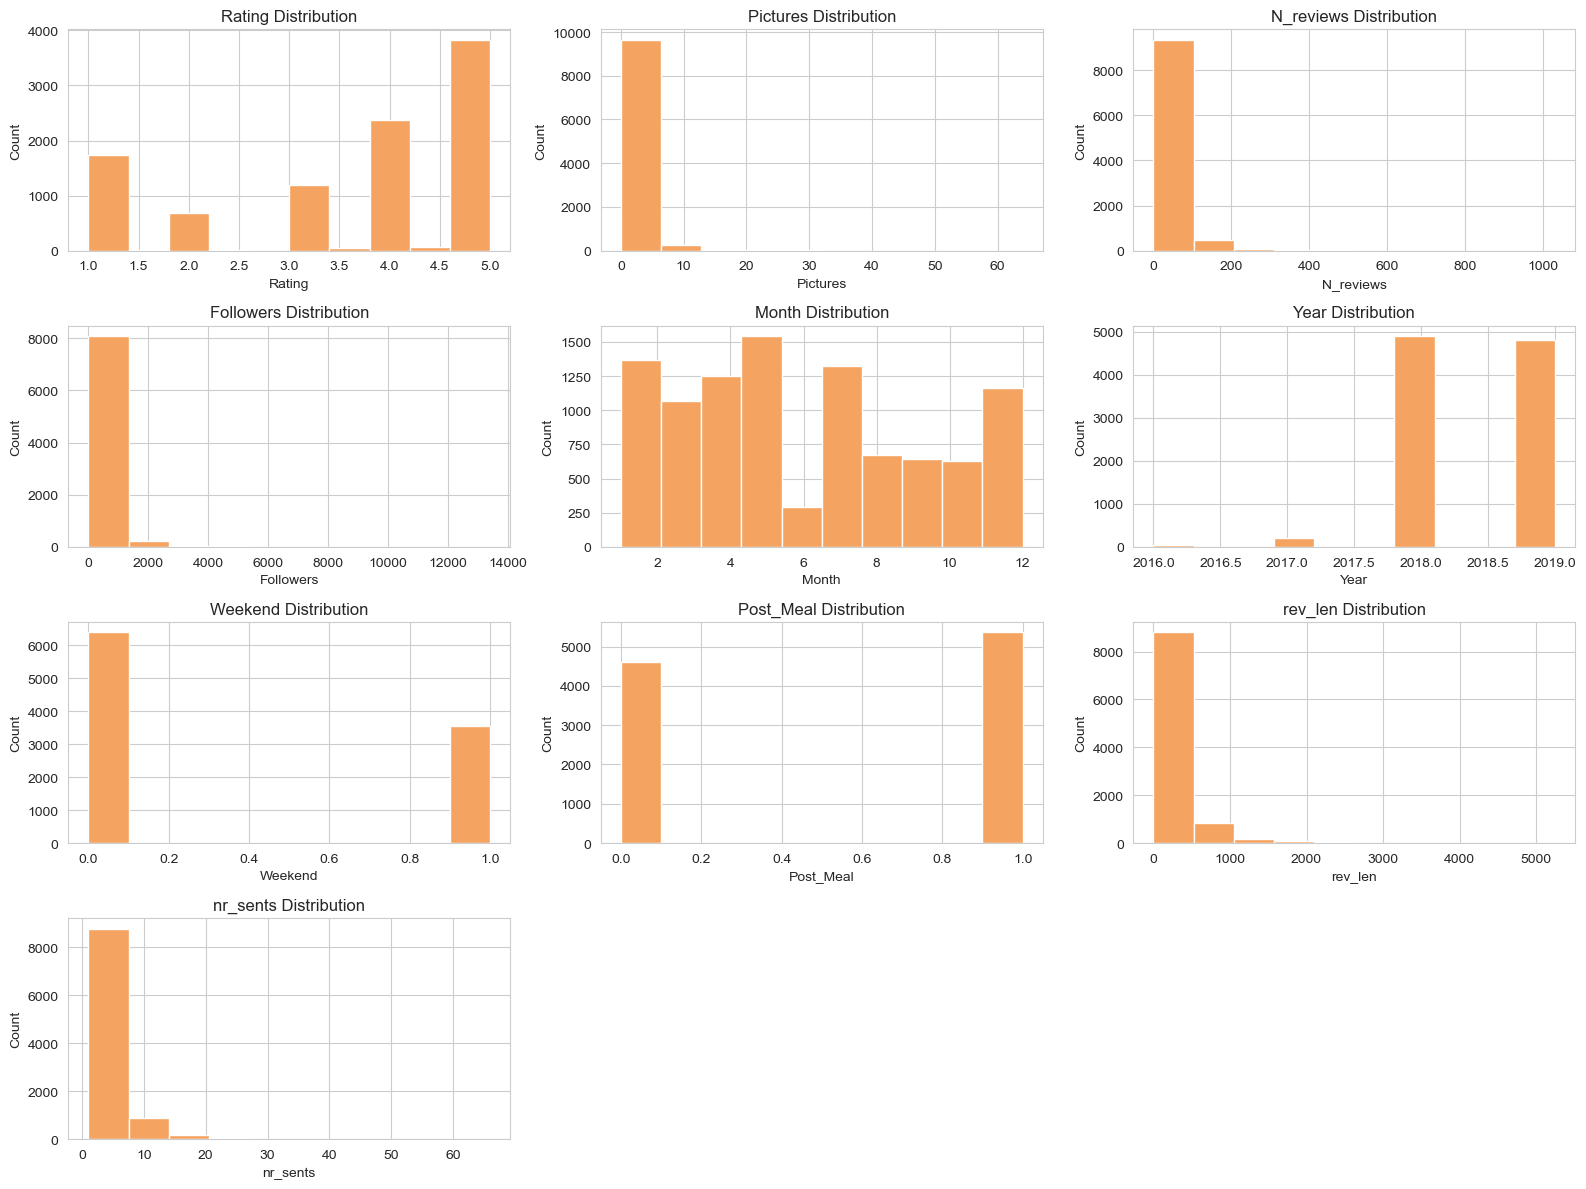

In [56]:
plot_histograms(reviews, ['Rating','Pictures','N_reviews','Followers','Month','Year','Weekend','Post_Meal','rev_len','nr_sents'])

Key Takeaways:
- The ratings are skewed towards the top.
- There are not much reviews in between of the common values (integers).
- Even though there are reviews from 2016 and 2017, the vast majority are from 2018 and 2019.
- Most of the variables follow the expected distribution - right skewed.

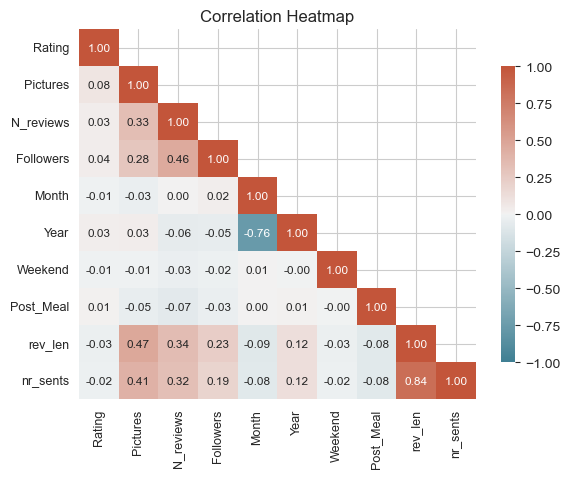

In [47]:
plot_heatmap(reviews)

It is expected the size of the review (rev_len and nr_sents) be correlated with the number of photos, number of reviews and number of followers as they will probably belong to more "professional" reviewers or that review more often.<br>
We will further analyse the relation between the number of reviews and followers a reviewer has.

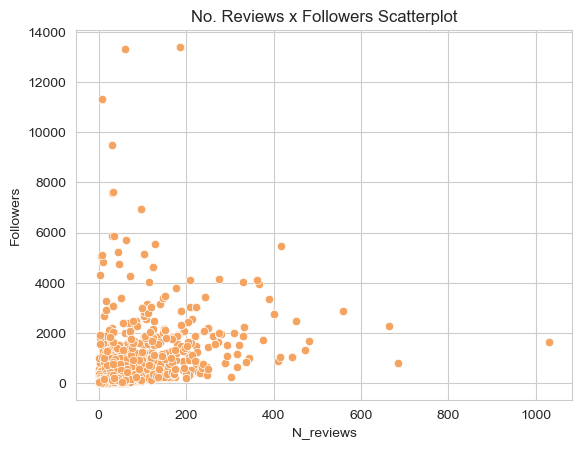

In [48]:
sns.scatterplot(reviews, x='N_reviews', y='Followers', c='sandybrown').set_title('No. Reviews x Followers Scatterplot')
plt.show()

Even though they have a correlation of 0.46, the scatterplot does not show any major connection between the variables.

In [49]:
print('Top Reviewers')
reviews['Reviewer'].value_counts().sort_values(ascending=False)

Top Reviewers


Ankita                   13
Parijat Ray              13
Kiran                    12
Jay Mehta                11
Vedant Killa             11
                         ..
Manish Singh              1
Kshitiz Goyal             1
Deepali K. Nagrani        1
Laxminarayana Amuraji     1
Bhargava Krishna          1
Name: Reviewer, Length: 7442, dtype: int64

In [50]:
print('How many reviews each restaurant has')
reviews['Restaurant'].value_counts().sort_values(ascending=True)

How many reviews each restaurant has


American Wild Wings                                   77
Arena Eleven                                          85
Hyderabad Chefs                                       98
Olive Garden                                          99
Being Hungry                                          99
                                                    ... 
Hyderabadi Daawat                                    100
Zega - Sheraton Hyderabad Hotel                      100
Triptify                                             100
Driven Cafe                                          100
Jonathan's Kitchen - Holiday Inn Express & Suites    100
Name: Restaurant, Length: 100, dtype: int64

We wanted to verify if there were any correlation between reviews that were published shortly after the reviewer has eaten in the restaurant and their rating.

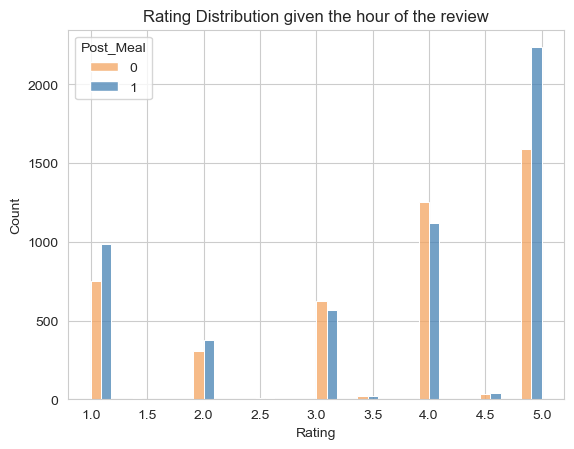

In [51]:
sns.histplot(reviews, 
             x='Rating', 
             hue='Post_Meal', 
             multiple='dodge', 
             palette=['sandybrown','steelblue']).set_title('Rating Distribution given the hour of the review')
plt.show()

In fact it was possible to check that the reviews published shortly after the meal had more extreme ratings than the ones published at other times.<br>
That goes along with our theory that people who have an exceptionally bad or good experience on a restaurant will want to publish their reviews right afterwards.

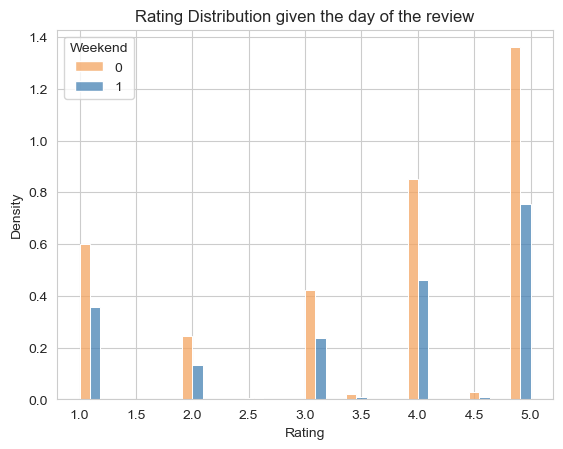

In [52]:
sns.histplot(reviews, 
             x='Rating', 
             hue='Weekend',
             multiple='dodge',
             stat='density',
             palette=['sandybrown','steelblue']).set_title('Rating Distribution given the day of the review')
plt.show()

Regarding the difference between reviews on weekdays and weekend we cannot draw a conclusion as there are naturally more reviews during the weekdays.

Let's see if a reviewer has given more than one review to the same restaurant.

In [57]:
review_counts = reviews.groupby(['Reviewer', 'Restaurant']).agg(
    mean_rating=('Rating','mean'),
    review_count=('Rating','count')).sort_values(by='review_count', ascending=False)

review_counts[review_counts['review_count'] > 1]

mean_rating  review_count
Reviewer         Restaurant                                   
Afreen Jahan     eat.fit                3.833333             6
Malar Madhav Rao Domino's Pizza         1.250000             4
Rahul Nayak      Amul                   5.000000             4
Rahul Jaiswal    Pakwaan Grand          2.750000             4
Kiran            Triptify               5.000000             4
...                                          ...           ...
Amlan Sahoo      Tempteys               4.500000             2
Chinni Vijay     Behrouz Biryani        5.000000             2
Yugandhar        Cream Stone            4.000000             2
Supriya Verma    Hunger Maggi Point     3.500000             2
P Arora          Triptify               4.500000             2

[94 rows x 2 columns]

### Word Clouds and Term Frequencies

In [104]:
trigram_bow_vectorizer = CountVectorizer(ngram_range=(1,3),max_features=150, token_pattern=r"(?u)\b\w+\b")
wc = WordCloud(background_color="white",max_words=150, width = 220,height = 220, color_func=lambda *args, **kwargs: (0,0,0))

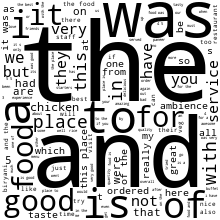

In [105]:
reviews_bow_td_matrix = trigram_bow_vectorizer.fit_transform(reviews["Review"]).toarray()
reviews["initial_bow_vector"] = reviews_bow_td_matrix.tolist()
reviews_bow_word_list = trigram_bow_vectorizer.get_feature_names_out()

reviews_raw_vocabulary = word_freq_calculator(reviews_bow_td_matrix,reviews_bow_word_list, df_output=False)
wc.generate_from_frequencies(reviews_raw_vocabulary)
wc.to_image()

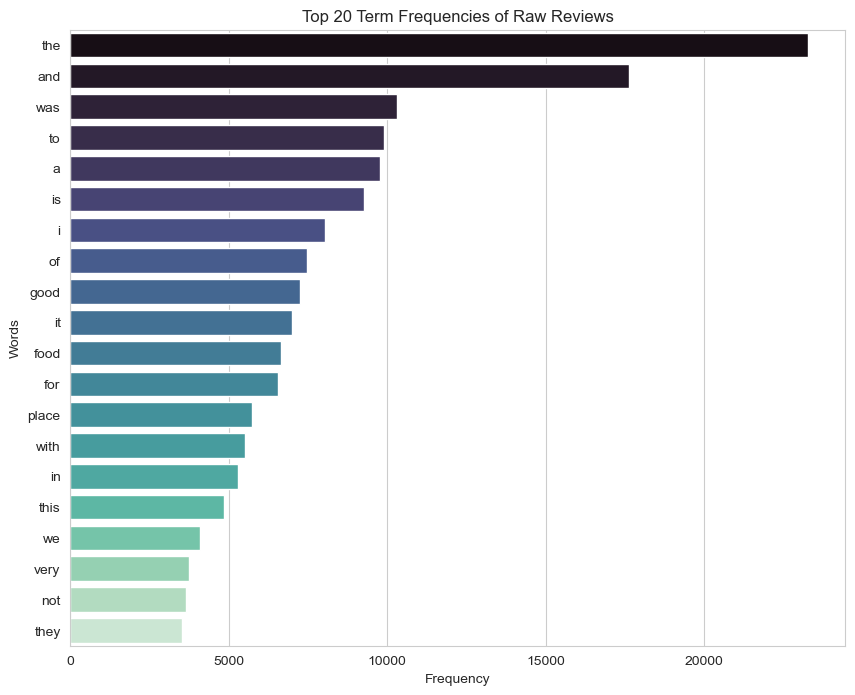

In [106]:
reviews_raw_vocabulary_df = word_freq_calculator(reviews_bow_td_matrix, reviews_bow_word_list, df_output=True)
plot_term_frequency(reviews_raw_vocabulary_df, 20, "Raw Reviews", show=False)

The text is densely populated with stopwords so let's remove them.

In [107]:
reviews["preproc_content"] =\
      reviews["Review"].map(lambda content : main_pipeline(content,
                                                            no_stopwords=True,
                                                            lowercase=True,
                                                            lemmatized=False,
                                                            stemmed=False,
                                                            no_punctuation=True,
                                                            tokenized_output=False,
                                                            word_correction=False
                                                            ))

In [ ]:
trigram_bow_vectorizer = CountVectorizer(ngram_range=(1,3),max_features=150, token_pattern=r"(?u)\b\w+\b")

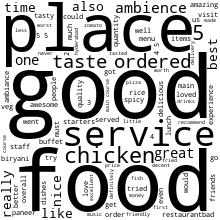

In [108]:
reviews_bow_td_matrix = trigram_bow_vectorizer.fit_transform(reviews["preproc_content"]).toarray()
reviews["initial_bow_vector"] = reviews_bow_td_matrix.tolist()
reviews_bow_word_list = trigram_bow_vectorizer.get_feature_names_out()

reviews_raw_vocabulary = word_freq_calculator(reviews_bow_td_matrix,reviews_bow_word_list, df_output=False)
wc.generate_from_frequencies(reviews_raw_vocabulary)
wc.to_image()

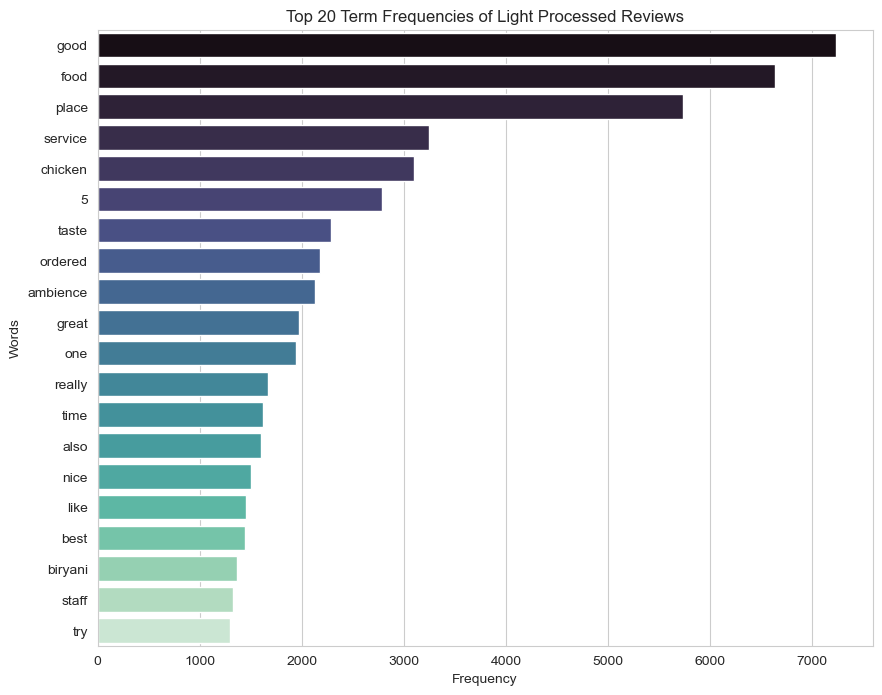

In [111]:
reviews_raw_vocabulary_df = word_freq_calculator(reviews_bow_td_matrix, reviews_bow_word_list, df_output=True)
plot_term_frequency(reviews_raw_vocabulary_df, 20, "Light Processed Reviews", show=False)

We will compare the different wordclouds for each cuisine type and collection.

In [110]:
reviews_with_cuisines = pd.merge(reviews, restaurants[['Name','Cuisines']], left_on='Restaurant', right_on='Name', how='left').explode('Cuisines')

In [ ]:
trigram_bow_vectorizer = CountVectorizer(ngram_range=(1,3),max_features=150, token_pattern=r"(?u)\b\w+\b")

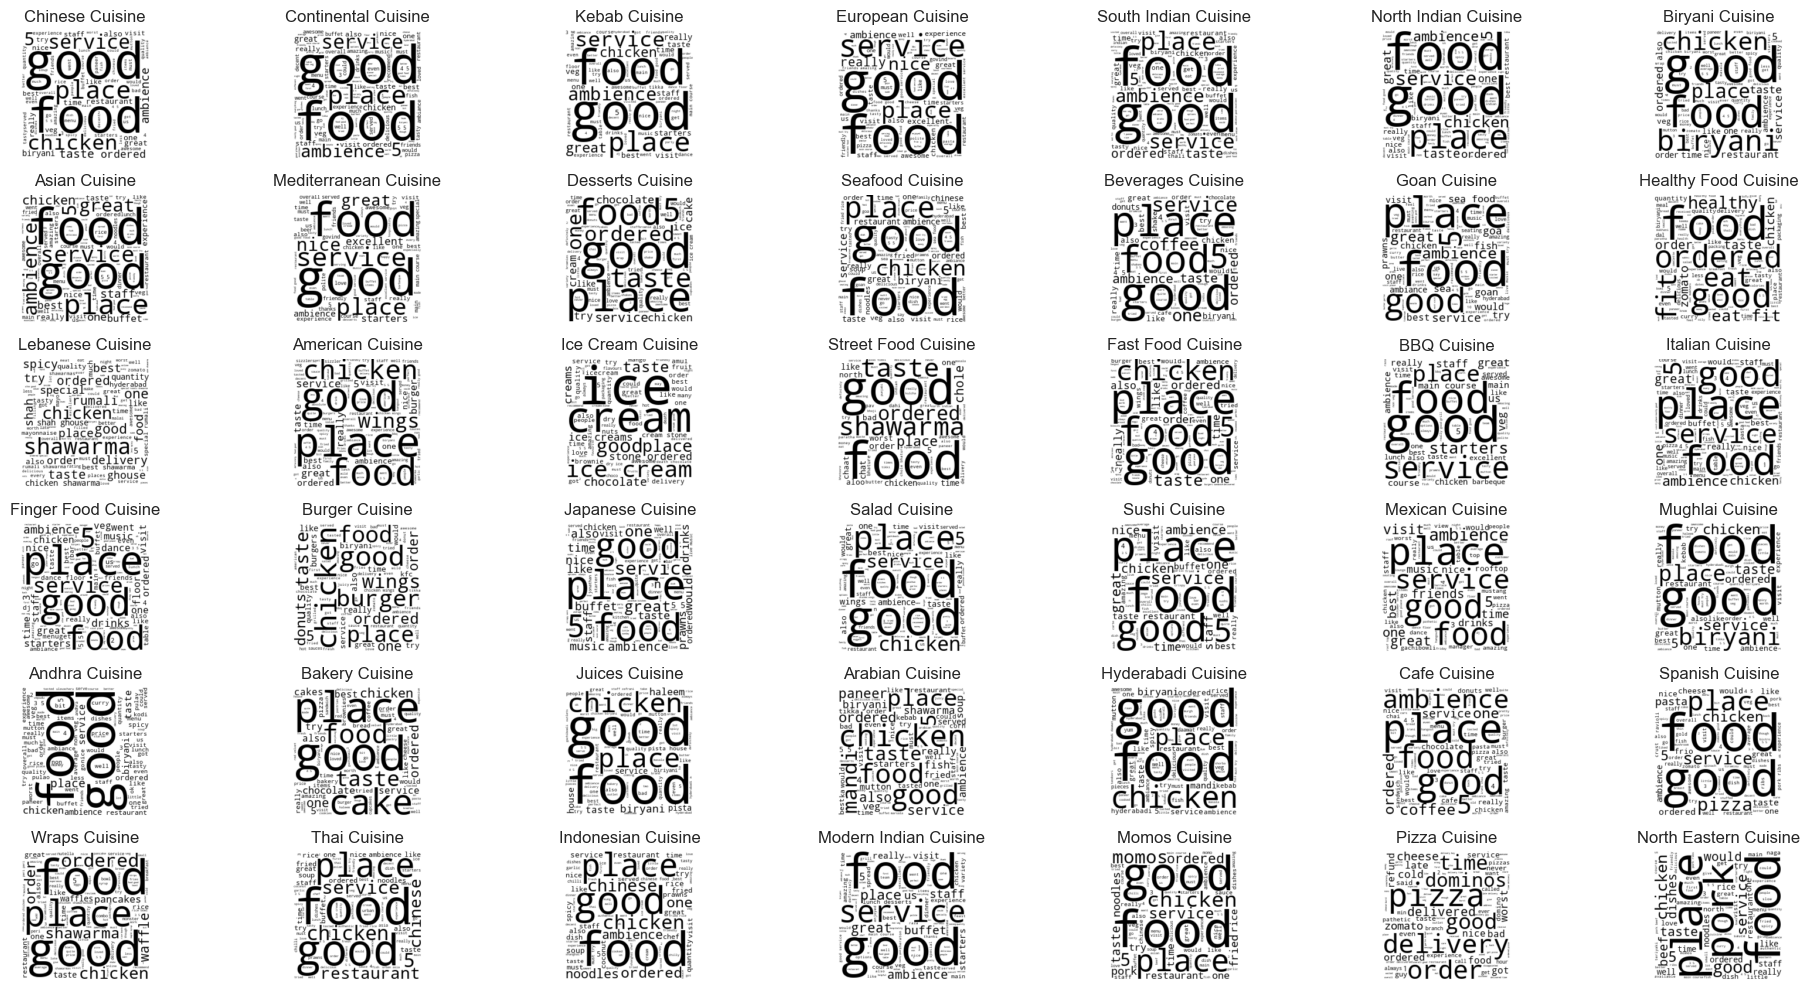

In [98]:
fig, axes = plt.subplots(nrows=6, ncols=7, figsize=(20, 10))
cuisine_types = reviews_with_cuisines['Cuisines'].unique()

for ax, cuisine in zip(axes.flatten(), cuisine_types):
    # Filter reviews for the current cuisine
    cuisine_reviews = reviews_with_cuisines[reviews_with_cuisines['Cuisines']==cuisine]
    
    if not cuisine_reviews.empty:
        cuisine_bow_td_matrix = trigram_bow_vectorizer.fit_transform(cuisine_reviews["preproc_content"]).toarray()
        cuisine_bow_word_list = trigram_bow_vectorizer.get_feature_names_out()
        
        cuisine_vocabulary = word_freq_calculator(cuisine_bow_td_matrix, cuisine_bow_word_list, df_output=False)
        wc.generate_from_frequencies(cuisine_vocabulary)
        
        ax.imshow(wc, interpolation='bilinear')
    else:
        ax.text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', fontsize=12)
    
    ax.axis('off')
    ax.set_title(f'{cuisine} Cuisine')

plt.tight_layout()
plt.show()
   

Even with stopwords, the wordclouds are densely populated by the words 'good', 'place' and 'food'. We will remove them and plot again.

In [102]:
def remove_words(text, words):
    for word in words:
        text = text.replace(word, '')
    return text

reviews_with_cuisines['preproc_content'] = reviews_with_cuisines['preproc_content'].apply(lambda x: remove_words(x, ['good','place','food']))

In [ ]:
trigram_bow_vectorizer = CountVectorizer(ngram_range=(1,3),max_features=150, token_pattern=r"(?u)\b\w+\b")

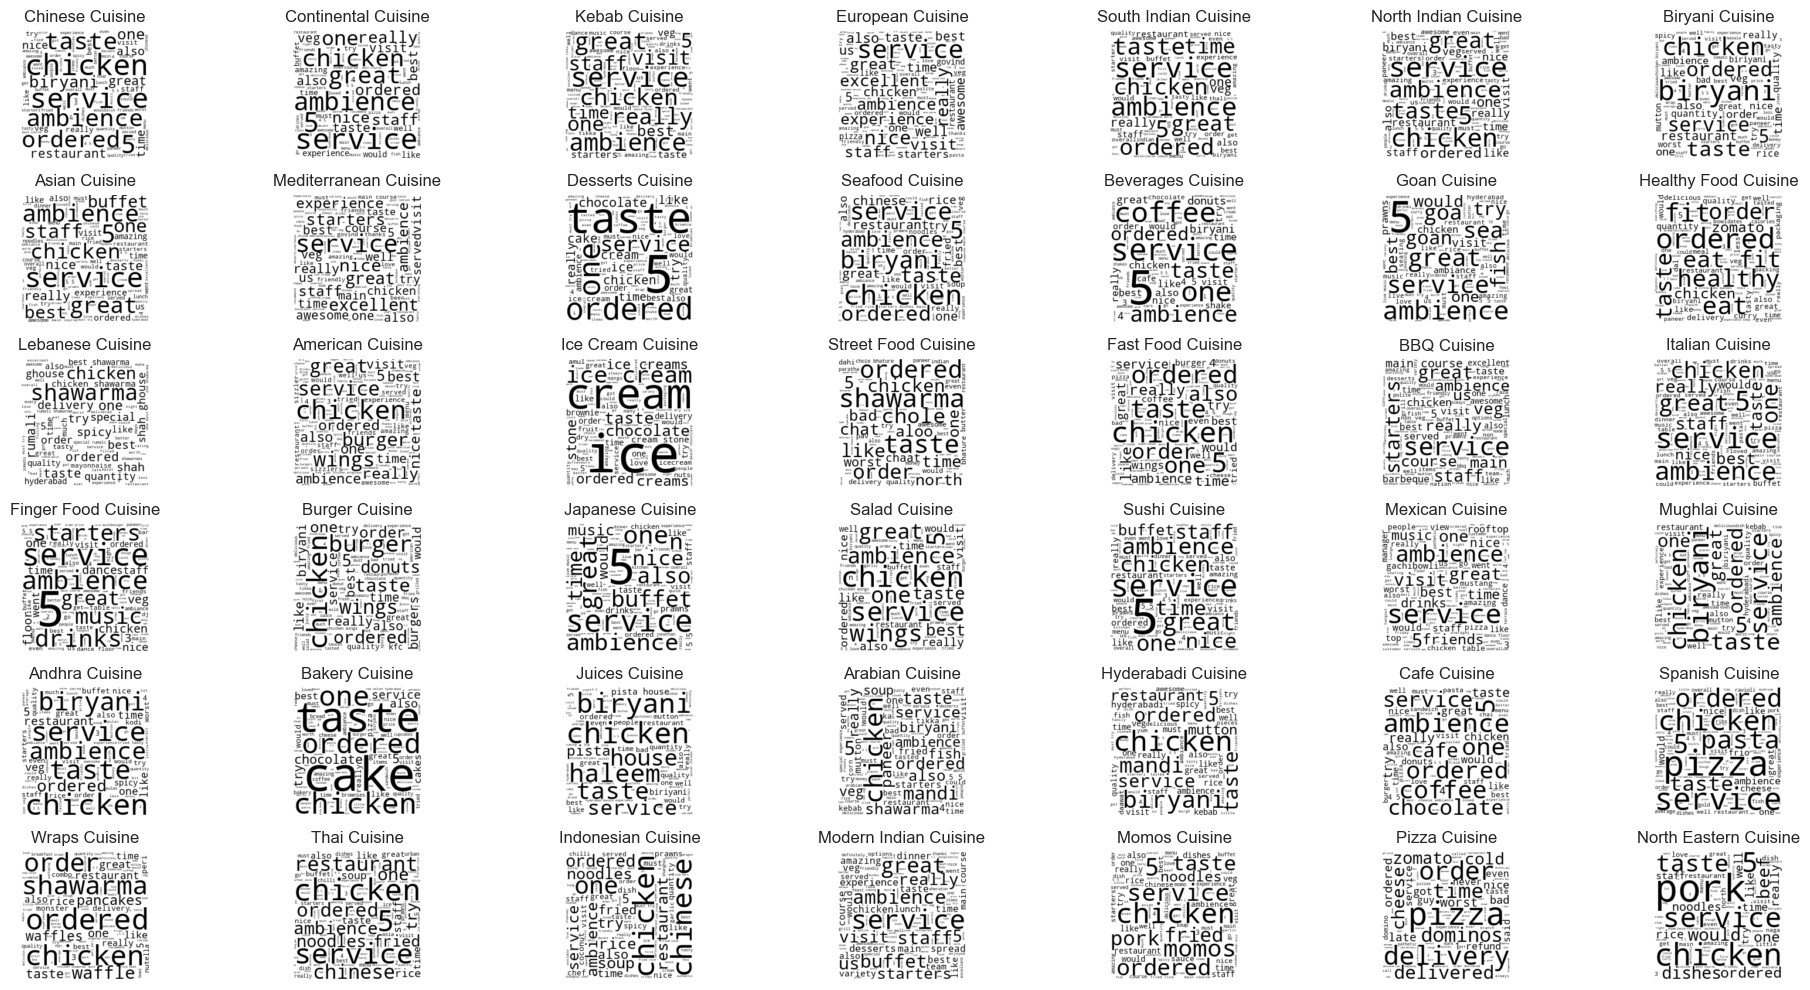

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols=7, figsize=(20, 10))
cuisine_types = reviews_with_cuisines['Cuisines'].unique()

for ax, cuisine in zip(axes.flatten(), cuisine_types):
    # Filter reviews for the current cuisine
    cuisine_reviews = reviews_with_cuisines[reviews_with_cuisines['Cuisines']==cuisine]
    
    if not cuisine_reviews.empty:
        cuisine_bow_td_matrix = trigram_bow_vectorizer.fit_transform(cuisine_reviews["preproc_content"]).toarray()
        cuisine_bow_word_list = trigram_bow_vectorizer.get_feature_names_out()
        
        cuisine_vocabulary = word_freq_calculator(cuisine_bow_td_matrix, cuisine_bow_word_list, df_output=False)
        wc.generate_from_frequencies(cuisine_vocabulary)
        
        ax.imshow(wc, interpolation='bilinear')
    else:
        ax.text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', fontsize=12)
    
    ax.axis('off')
    ax.set_title(f'{cuisine} Cuisine')

plt.tight_layout()
plt.show()

In [115]:
reviews_with_collections = pd.merge(reviews, restaurants[['Name','Collections']], left_on='Restaurant', right_on='Name', how='left').explode('Collections')

In [116]:
reviews_with_collections['preproc_content'] = reviews_with_collections['preproc_content'].apply(lambda x: remove_words(x, ['good','place','food']))

In [117]:
reviews_with_collections['Collections'].nunique()

37

In [119]:
trigram_bow_vectorizer = CountVectorizer(ngram_range=(1,3),max_features=150, token_pattern=r"(?u)\b\w+\b")

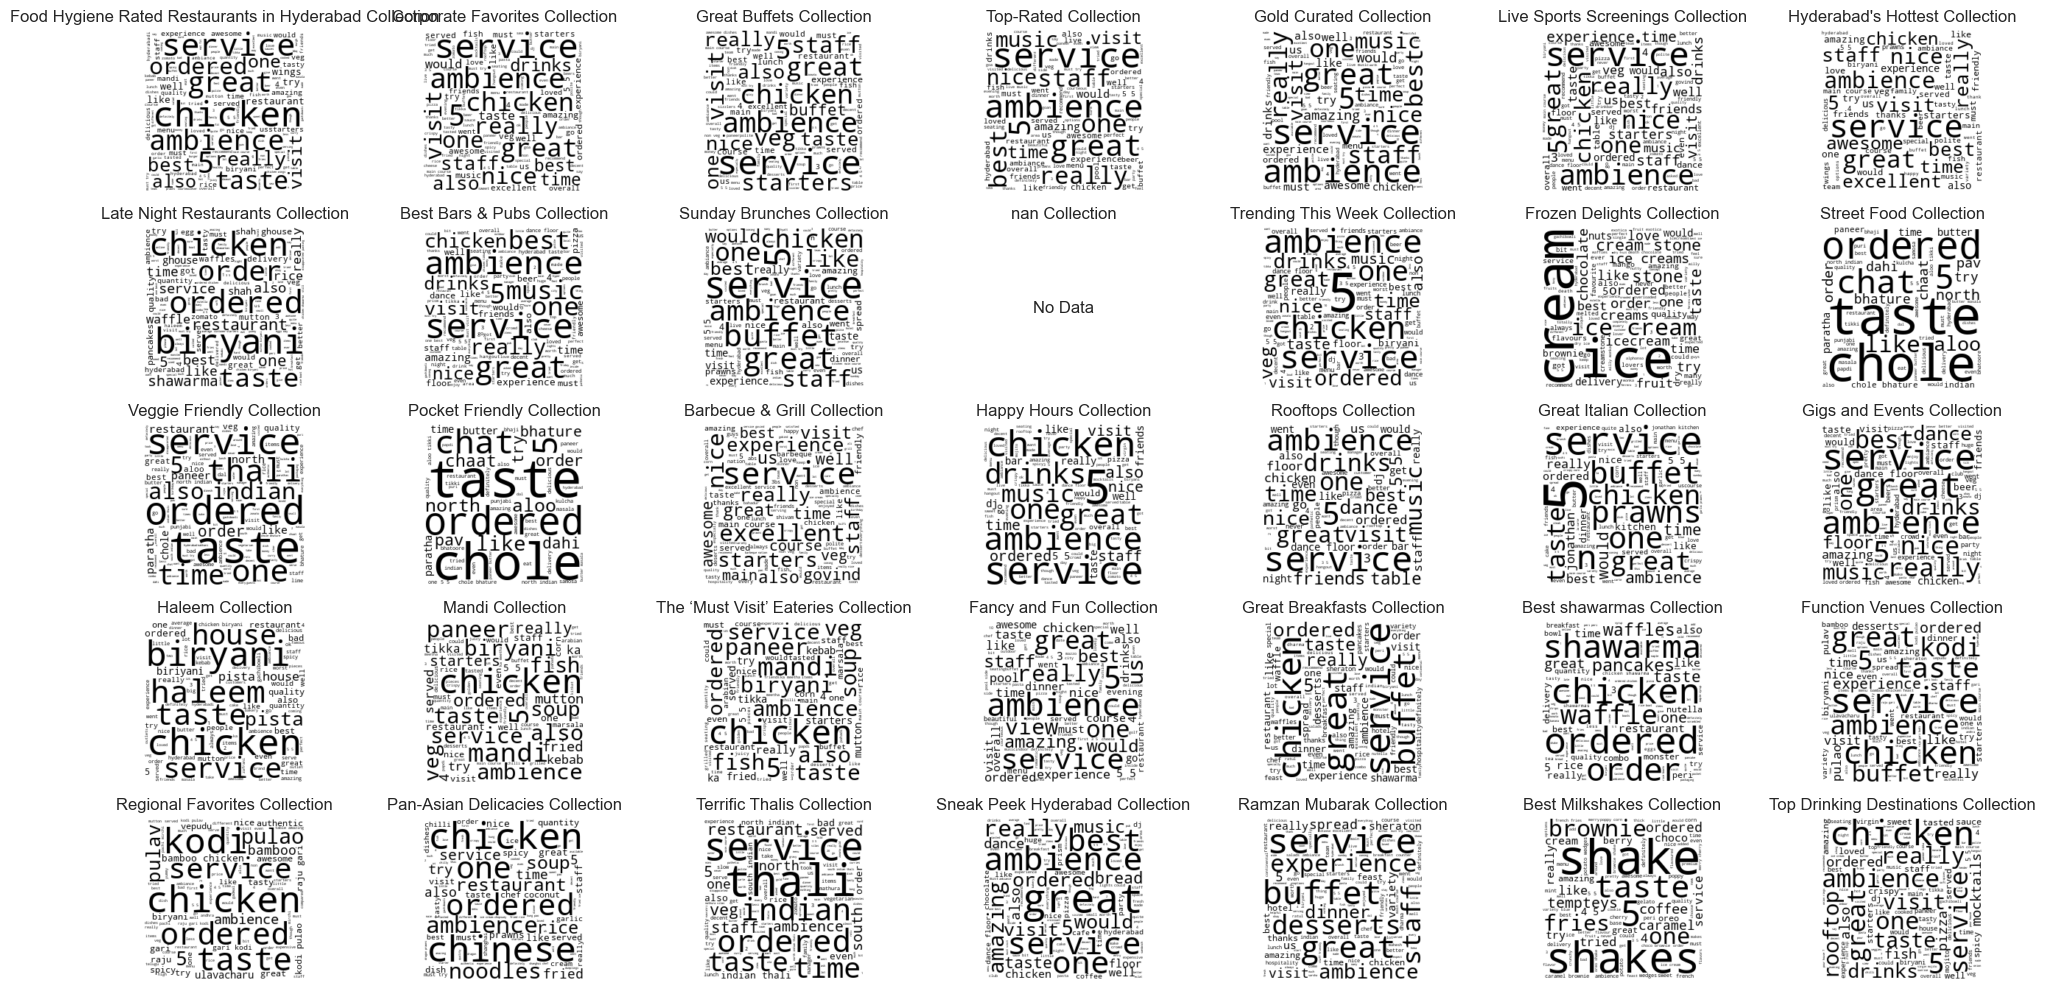

In [121]:
fig, axes = plt.subplots(nrows=5, ncols=7, figsize=(20, 10))
collection_types = reviews_with_collections['Collections'].unique()

for ax, collection in zip(axes.flatten(), collection_types):
    # Filter reviews for the current collection
    collection_reviews = reviews_with_collections[reviews_with_collections['Collections']==collection]
    
    if not collection_reviews.empty:
        collection_bow_td_matrix = trigram_bow_vectorizer.fit_transform(collection_reviews["preproc_content"]).toarray()
        collection_bow_word_list = trigram_bow_vectorizer.get_feature_names_out()
        
        collection_vocabulary = word_freq_calculator(collection_bow_td_matrix, collection_bow_word_list, df_output=False)
        wc.generate_from_frequencies(collection_vocabulary)
        
        ax.imshow(wc, interpolation='bilinear')
    else:
        ax.text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', fontsize=12)
    
    ax.axis('off')
    ax.set_title(f'{collection} Collection')

plt.tight_layout()
plt.show()